# Environment setup

Follow the tutorial about how to utilize Google Colab but don't install PyTorch as mentioned in the blog post.

Turkish: https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English: https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d


## Don't forget to choose the right runtime from the menu above. (GPU should be selected)


In [0]:
!nvidia-smi

Thu Jan  3 12:21:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!pip3 install torch==0.4.1
!pip3 install torchvision==0.2.1
!pip3 install scipy
!pip3 install numpy
!pip3 install matplotlib
!pip3 install quandl
!pip3 install pandas

    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59988000 @  0x7f0fab2852a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 4.8MB/s 
    100% |████████████████████████████████| 2.0MB 10.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Running setup.py bdist_wheel for inflection ... - done
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


Register to Quandl

For this homework, you will use data from Frankfurt Stock Exchange, Quandl (www.quandl.com) provides the required data . https://www.quandl.com/data/FSE-Frankfurt-Stock-Exchange

In the following link, the details about how to download the is given. Before sending your homework, do not forget to clear your API key from the notebook, for the sake of privacy. https://www.quandl.com/data/FSE-Frankfurt-Stock-Exchange/usage/quickstart/python


Instructions

    In this homework, you will be implementing your own RNN/LSTM/GRU models and try to predict stock price of BMW using previous values of BMW, Daimler stocks and stock index.
    Write your dataloader to feed your data. You need to normalize your data, there are various approaches but for simplicity, you can simply scale it between [0,1] If you want to do something extra for more points, you can try the followings:
        remove seasonality
        instead of predicting the price, predict the return (i.e. how much will it increase in the next step)
        merge the current data with something extra (for example, add stocks for General Motors)
    You can use 30 as window length (sequence length) for your models.
    If you think that something is wrong, you can try to fit your model to a sine wave.
    For each model(RNN/LSTM/GRU) report the predictions for both the test and training data, and the loss curves.



In [0]:
import quandl
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.preprocessing import normalize

In [0]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
YOUR_API_KEY = ''
quandl.ApiConfig.api_key = YOUR_API_KEY
data = quandl.get(['FSE/BMW_X', 'FSE/DAI_X', 'FSE/DB1_X'], start_date='2009-01-01', end_date='2018-12-19', column_index= '4')
data = data.dropna().ffill()
data_train = data[:-500] 
data_test = data[-500:]

In [0]:
data_train = data_train.values
data_test = data_test.values

In [0]:
np.random.seed(0)
torch.manual_seed(0)

input = torch.from_numpy(data_train[:-1])
target = torch.from_numpy(data_train[1:])
test_input = torch.from_numpy(data_test[:-1])
test_target = torch.from_numpy(data_test[1:])

input = normalize(input, axis=1).T
target = normalize(target, axis=1).T
test_input = normalize(test_input, axis=1).T
test_target = normalize(test_target, axis=1).T

input = torch.from_numpy(input).cuda()
target = torch.from_numpy(target).cuda()
test_input = torch.from_numpy(test_input).cuda()
test_target = torch.from_numpy(test_target).cuda()

In [153]:
    # This version is highly inspired by https://github.com/pytorch/examples/blob/master/time_sequence_prediction
    seq = Sequence()
    seq.double().cuda()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
    #begin to train
    out_l = []
    loss_s = []
    for i in range(5):
        print('STEP: ', i)
        def closure():
            optimizer.zero_grad()
            out = seq(input)            
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            out_l.append(out)
            return loss
        optimizer.step(closure)
        # begin to predict, no need to track gradient here
        with torch.no_grad():
            pred = seq(test_input)
            loss = criterion(pred, test_target)
            loss_s.append(loss)
            print('test loss:', loss.item())
            y = pred.cpu().detach().numpy()
            
            
        
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    
    plt.plot(y.T,linewidth = 5.7)
    plt.plot(test_target.cpu().numpy().T,linewidth = 0.7)
    plt.imshow
    plt.savefig('final_loss.pdf')
    plt.close()
        

STEP:  0
loss: 0.4566156121708365
loss: 0.3860102781671906
loss: 0.01627999670673175
loss: 0.01132717884665716
loss: 0.011319540985776267
loss: 0.011314334678191975
loss: 0.011298771721647593
loss: 0.011263915504281507
loss: 0.011180868122807806
loss: 0.010970752771740805
loss: 0.010166278976416157
loss: 0.008856552443276426
loss: 0.0060755331335245084
loss: 0.005364256098418997
loss: 0.004313394595898093
loss: 0.003622001592832038
loss: 0.004749946949281186
loss: 0.000603639198963348
loss: 0.0002836214739064976
loss: 0.0001560525229339295
test loss: 0.00013769416427451692
STEP:  1
loss: 0.00014897837884728424
loss: 0.00014888881215516486
loss: 0.00014887296276161786
loss: 0.00014884500871913185
loss: 0.0001487795583999963
loss: 0.00014862827441704805
loss: 0.00014827930123519675
loss: 0.00014748570900575842
loss: 0.00014574435802842603
loss: 0.0001422490929895104
loss: 0.00013642283100587092
loss: 0.00012867629746066505
loss: 0.00011711908273824991
loss: 0.00011059389762138331
loss: 0

## Predicted Values vs Test Values (LSTM)

<function matplotlib.pyplot.imshow>

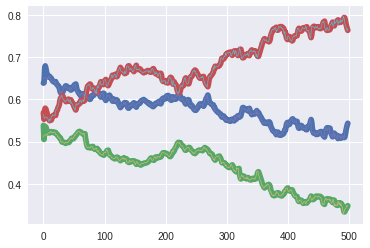

In [154]:
plt.plot(y.T,linewidth = 5.7)
plt.plot(test_target.cpu().numpy().T,linewidth = 0.7)
plt.imshow

## Loss values (LSTM)

<function matplotlib.pyplot.imshow>

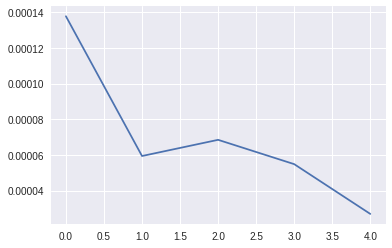

In [161]:
plt.close()
plt.plot(loss_s)
plt.imshow
    